<a href="https://colab.research.google.com/github/seungmindavid/Representational-Learning/blob/main/VAE/SVAE_CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from torch.utils.data import DataLoader

from IPython.display import Image
from IPython.core.display import Image, display
from torchvision.utils import save_image
from torchsummary import summary


In [2]:
if torch.cuda.is_available():
  device = torch.device("cuda:0")
  print("GPU")
else:
  device = torch.device("cpu")
  print("CPU")
#device = torch.device("cpu")

GPU


In [3]:
batch_size_train = 128
batch_size_test = 10
img_size = 28

transform = torchvision.transforms.Compose([
    torchvision.transforms.Resize(img_size),
    torchvision.transforms.ToTensor(),
    #torchvision.transforms.Normalize([0.5], [0.5]),
    torchvision.transforms.Lambda(lambda x: x*255)
])

train_loader = torch.utils.data.DataLoader(
    torchvision.datasets.MNIST('./data', train=True, download= True, transform=transform),
    batch_size = batch_size_train, shuffle=True
)

test_loader = torch.utils.data.DataLoader(
    torchvision.datasets.MNIST('./data', train=False, download=True, transform=transform),
    batch_size = batch_size_test, shuffle=False
)

100%|██████████| 9912422/9912422 [00:00<00:00, 88015698.06it/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 23394301.63it/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 27011824.29it/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 17754453.65it/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



### MNIST Dataset
- Input shape: 1 channel (since it's greyscale immage), 28⋅28 pixels.
- Encoder: 1⋅28⋅28 → 32⋅14⋅14 → 64⋅7⋅7 → Flatten (64*7*7)→ 256
- VAE: Encoder → μ,σ → z → Decoder
- Decoder: 256 → 64*7*7 → 64⋅7⋅7 → 32⋅14⋅14 → 1⋅28⋅28

In [4]:
class VAE(nn.Module):
    def __init__(self, latent_dim, img_size):
        super(VAE, self).__init__()

        self.encoder = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=4, stride=2, padding=1),
            #nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=4, stride=2, padding=1),
            #nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Flatten(),
            nn.Linear(64 * (img_size // 4) * (img_size // 4), 256),
            nn.ReLU()
        )

        self.fc_mu = nn.Linear(256, latent_dim)
        self.fc_logvar = nn.Linear(256, latent_dim)

        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, 256),
            nn.ReLU(),
            nn.Linear(256, 64 * (img_size // 4) * (img_size // 4)),
            nn.ReLU(),
            nn.Unflatten(1, (64, img_size // 4, img_size // 4)),
            nn.ConvTranspose2d(64, 32, kernel_size=4, stride=2, padding=1),
            #nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.ConvTranspose2d(32, 1, kernel_size=4, stride=2, padding=1),
            #nn.BatchNorm2d(1)
            #nn.Sigmoid() #we don't append activation function on last layer
        )

    def reparameterize_sampling(self, mu, logvar):
        #std = torch.exp(0.5 * logvar)
        std = logvar.exp().sqrt()
        eps = torch.randn_like(mu).to(device)
        return mu + eps * std

    def forward(self, x):
        x = self.encoder(x)
        mu = self.fc_mu(x)
        logvar = self.fc_logvar(x)
        z = self.reparameterize_sampling(mu, logvar)
        x_reconstructed = self.decoder(z)
        return x_reconstructed, mu, logvar

    def decode(self, z):
      return self.decoder(z)


# Loss Construction (EBLO)

$\log p(x) \geq \log p(x|z) - KL[q(z|x)||p(x)]$

And we want minimal loss (convert $+ \rightarrow -$)


$L = -\log p(x) = \log p(x|c,z) + KL[q(z|x)||p(x)]$

$-\log p(x|c,z)$ : MSE is built in Pytorch

$\text{KL}[q(z|x)||p(x)]$ (Regularizer) : $q(z|x)$ doesn't rely on c value and p(x) also not since $p(x) = N(0,I)$.

$
\text{KL}[q(z|x)||p(x)] = 0.5 (-\text{tr}\log \Sigma_q - k + \text{tr}\Sigma_q + \mu_q^T \mu_q)
$

In [5]:
def KL_div_N01(z_mu, z_log_sigma_sq):
  term_1 = z_log_sigma_sq.sum(axis=1) # trace log Sigma q
  term_2 = z_log_sigma_sq.exp().sum(axis=1) # trace Sigma q
  term_3 = (z_mu*z_mu).sum(axis=1) # this is mu_q squared and summed
  return 0.5*(-term_1 + term_2 + term_3 - z_mu.shape[1]).mean()

def kl_divergence(mu, logvar):
    kld_loss = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return kld_loss

MSELoss = torch.nn.MSELoss()



In [16]:

class SupervisedVAE(nn.Module):
    def __init__(self, latent_dim, img_size, num_classes):
        super(SupervisedVAE, self).__init__()
        self.vae = VAE(latent_dim, img_size)
        self.classifier = nn.Sequential(
            nn.Linear(latent_dim, 256),
            nn.ReLU(),
            nn.Linear(256, num_classes)
        )

    def forward(self, x):
        x_reconstructed, mu, logvar = self.vae(x)
        class_logits = self.classifier(mu)
        return x_reconstructed, mu, logvar, class_logits




In [17]:
import pathlib

saved_params_path = "./saved_params_svae"
pathlib.Path(f"./{saved_params_path}/").mkdir(parents=True, exist_ok=True)
latent_dim = 2
img_size = 28
num_classes = 10
lr = 3e-4
num_epochs = 50

SVAE = SupervisedVAE(latent_dim, img_size, num_classes).to(device)
optimizer = optim.Adam(SVAE.parameters(), lr=lr)

for epoch in range(num_epochs):
    for batch_idx, (x, labels) in enumerate(train_loader, 0):
        x = x.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()
        x_reconstructed, mu, logvar, class_logits = SVAE.forward(x)

        mse_loss = MSELoss(x_reconstructed, x)
        #bce_loss = BCELoss(x_reconstructed, x)
        # Beta-VAE, Beta =1.5
        KL_div_loss = kl_divergence(mu, logvar)
        classification_loss = F.cross_entropy(class_logits, labels)

        total_loss = mse_loss + KL_div_loss + classification_loss
        total_loss.backward()
        optimizer.step()

        if batch_idx % 100 == 0:
            print(f"Epoch {epoch}/{num_epochs}, Batch {batch_idx}/{len(train_loader)}, Loss: {total_loss.item():.2f}")
    torch.save(SVAE.state_dict(), f'{saved_params_path}/{epoch}.pth')

# Save the trained model
torch.save(SVAE.state_dict(), 'supervised_vae.pth')



Epoch 0/50, Batch 0/469, Loss: 7220.91
Epoch 0/50, Batch 100/469, Loss: 4040.75
Epoch 0/50, Batch 200/469, Loss: 3551.95
Epoch 0/50, Batch 300/469, Loss: 3474.62
Epoch 0/50, Batch 400/469, Loss: 3371.38
Epoch 1/50, Batch 0/469, Loss: 3548.07
Epoch 1/50, Batch 100/469, Loss: 3423.98
Epoch 1/50, Batch 200/469, Loss: 3242.66
Epoch 1/50, Batch 300/469, Loss: 3423.16
Epoch 1/50, Batch 400/469, Loss: 3131.53
Epoch 2/50, Batch 0/469, Loss: 3115.12
Epoch 2/50, Batch 100/469, Loss: 3199.25
Epoch 2/50, Batch 200/469, Loss: 3119.12
Epoch 2/50, Batch 300/469, Loss: 2999.93
Epoch 2/50, Batch 400/469, Loss: 3199.04
Epoch 3/50, Batch 0/469, Loss: 3081.48
Epoch 3/50, Batch 100/469, Loss: 3019.12
Epoch 3/50, Batch 200/469, Loss: 3034.21
Epoch 3/50, Batch 300/469, Loss: 2793.32
Epoch 3/50, Batch 400/469, Loss: 2956.36
Epoch 4/50, Batch 0/469, Loss: 3116.68
Epoch 4/50, Batch 100/469, Loss: 2778.75
Epoch 4/50, Batch 200/469, Loss: 2997.89
Epoch 4/50, Batch 300/469, Loss: 3001.54
Epoch 4/50, Batch 400/469,

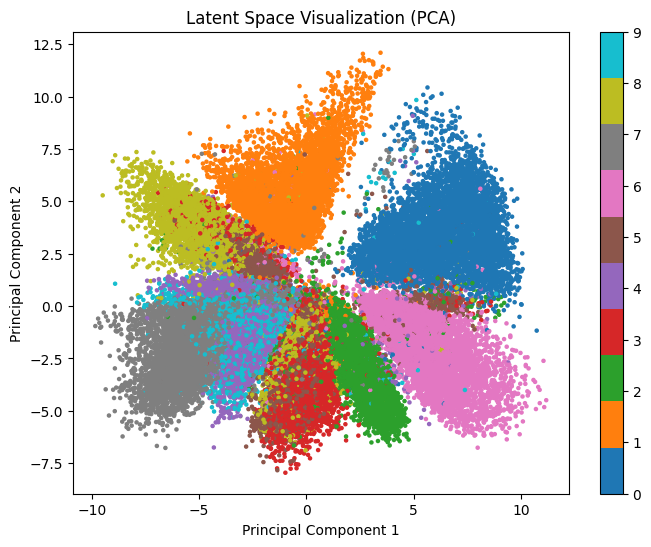

In [18]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

# Load your trained model
latent_dim = 2  # Adjust this according to your model

model = SupervisedVAE(latent_dim, img_size, num_classes).to(device)
model.load_state_dict(torch.load('supervised_vae.pth'))
model.eval()

# Define a function to encode the dataset into the latent space
def encode_dataset(model, dataloader):
    encoded_data = []
    labels = []
    with torch.no_grad():
        for x, label in dataloader:
            x = x.to(device)
            label = label.to(device)
            _, mu, _ = model.vae.forward(x)
            encoded_data.append(mu.cpu().numpy())
            labels.append(label.cpu().numpy())
    encoded_data = np.concatenate(encoded_data)
    labels = np.concatenate(labels)
    return encoded_data, labels

# Encode the dataset into the latent space
encoded_data, labels = encode_dataset(model, train_loader)

n_components = 2
pca = PCA(n_components=n_components)
reduced_data = pca.fit_transform(encoded_data)

# Plot the reduced latent space
plt.figure(figsize=(8, 6))
plt.scatter(reduced_data[:, 0], reduced_data[:, 1], c=labels, cmap='tab10', s=5)
plt.colorbar()
plt.title('Latent Space Visualization (PCA)')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.show()


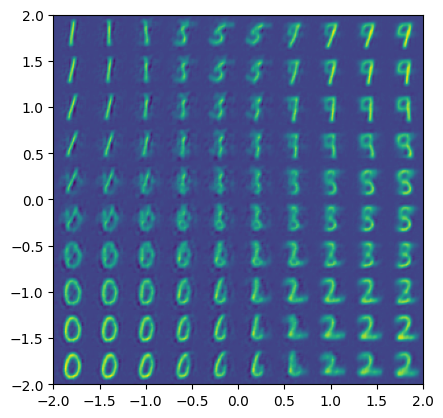

In [19]:
import seaborn as sns
from matplotlib import pyplot as plt

%matplotlib inline

def plot_reconstructed(model, ranges=((-2,2),(-2,2)), n_sample_points=10, image_dim=28):

    img = np.zeros((n_sample_points*image_dim, n_sample_points*image_dim))

    for i, y in enumerate(np.linspace(*ranges[0], n_sample_points)):
        for j, x in enumerate(np.linspace(*ranges[1], n_sample_points)):
            z = torch.Tensor([[x, y]])
            z = z.to(device)

            x_hat = model.vae.decode(z)
            x_hat = x_hat.cpu().detach().numpy()
            img[
                (n_sample_points-1-i)*image_dim:(n_sample_points-1-i+1)*image_dim,
                j*image_dim:(j+1)*image_dim] = x_hat

    plt.imshow(img, extent=[*ranges[0], *ranges[1]])


model = SupervisedVAE(latent_dim, img_size, num_classes).to(device)
model.load_state_dict(torch.load('supervised_vae.pth'))
model.eval()

plot_reconstructed(model)

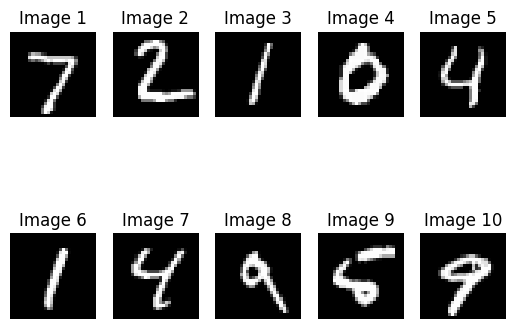

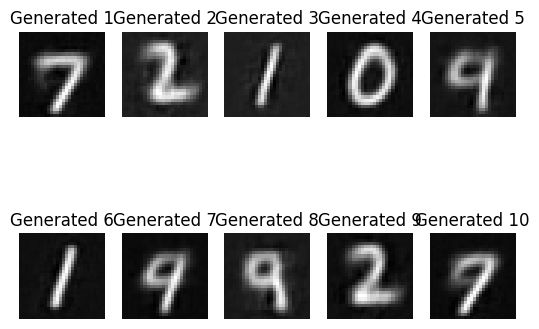

In [20]:
import torch
import matplotlib.pyplot as plt



batch = next(iter(test_loader))
images, labels = batch
# Assuming img_tensor is your torch tensor with size [10, 1, 28, 28]
img_tensor = torch.randn(10, 1, 28, 28)

# Loop through the batch and plot each image
for i in range(10):
    # Convert the tensor to numpy array
    img_array = images[i].squeeze().detach().numpy()

    # Plot the image
    plt.subplot(2, 5, i+1)  # Assuming a 2x5 grid for the subplots
    plt.imshow(img_array, cmap='gray')
    plt.axis('off')  # Turn off axis labels
    plt.title(f'Image {i+1}')

plt.show()

epoch = 9
model = SupervisedVAE(latent_dim, img_size, num_classes).to(device)
model.load_state_dict(torch.load('supervised_vae.pth'))

model.eval()

images = images.to(device)
labels = labels.to(device)

x_reconstructed, mu, logvar, class_logits = model.forward(images)

# Loop through the batch and plot each image
for i in range(10):
    # Convert the tensor to numpy array
    img_array = x_reconstructed[i].squeeze().cpu().detach().numpy()
    #img_array = np.clip(img_array/255.,0,1)
    # Plot the image
    plt.subplot(2, 5, i+1)  # Assuming a 2x5 grid for the subplots
    plt.imshow(img_array, cmap='gray')
    plt.axis('off')  # Turn off axis labels
    plt.title(f'Generated {i+1}')

plt.show()

In [6]:
import pathlib

saved_params_path = "./saved_params_vae"
pathlib.Path(f"./{saved_params_path}/").mkdir(parents=True, exist_ok=True)
latent_dim = 2
img_size = 28
num_classes = 10
lr = 3e-4
num_epochs = 50

vae_instance = VAE(latent_dim, img_size).to(device)
optimizer = optim.Adam(vae_instance.parameters(), lr=lr)

for epoch in range(num_epochs):
    for batch_idx, (x, labels) in enumerate(train_loader, 0):
        x = x.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()
        x_reconstructed, mu, logvar = vae_instance.forward(x)

        mse_loss = MSELoss(x_reconstructed, x)
        KL_div_loss = KL_div_N01(mu, logvar)

        total_loss = mse_loss + KL_div_loss
        total_loss.backward()
        optimizer.step()

        if batch_idx % 100 == 0:
            print(f"Epoch {epoch}/{num_epochs}, Batch {batch_idx}/{len(train_loader)}, Loss: {total_loss.item():.2f}")
    torch.save(vae_instance.state_dict(), f'{saved_params_path}/{epoch}.pth')

# Save the trained model
torch.save(vae_instance.state_dict(), 'vae.pth')



Epoch 0/50, Batch 0/469, Loss: 6791.59
Epoch 0/50, Batch 100/469, Loss: 4143.13
Epoch 0/50, Batch 200/469, Loss: 3593.27
Epoch 0/50, Batch 300/469, Loss: 3600.89
Epoch 0/50, Batch 400/469, Loss: 3480.60
Epoch 1/50, Batch 0/469, Loss: 3272.91
Epoch 1/50, Batch 100/469, Loss: 3443.34
Epoch 1/50, Batch 200/469, Loss: 3341.51
Epoch 1/50, Batch 300/469, Loss: 3171.29
Epoch 1/50, Batch 400/469, Loss: 3113.02
Epoch 2/50, Batch 0/469, Loss: 3244.66
Epoch 2/50, Batch 100/469, Loss: 3170.01
Epoch 2/50, Batch 200/469, Loss: 3034.96
Epoch 2/50, Batch 300/469, Loss: 3021.58
Epoch 2/50, Batch 400/469, Loss: 3165.34
Epoch 3/50, Batch 0/469, Loss: 3154.90
Epoch 3/50, Batch 100/469, Loss: 2971.10
Epoch 3/50, Batch 200/469, Loss: 3120.56
Epoch 3/50, Batch 300/469, Loss: 2941.53
Epoch 3/50, Batch 400/469, Loss: 2849.62
Epoch 4/50, Batch 0/469, Loss: 2880.44
Epoch 4/50, Batch 100/469, Loss: 2990.80
Epoch 4/50, Batch 200/469, Loss: 3063.06
Epoch 4/50, Batch 300/469, Loss: 2982.15
Epoch 4/50, Batch 400/469,

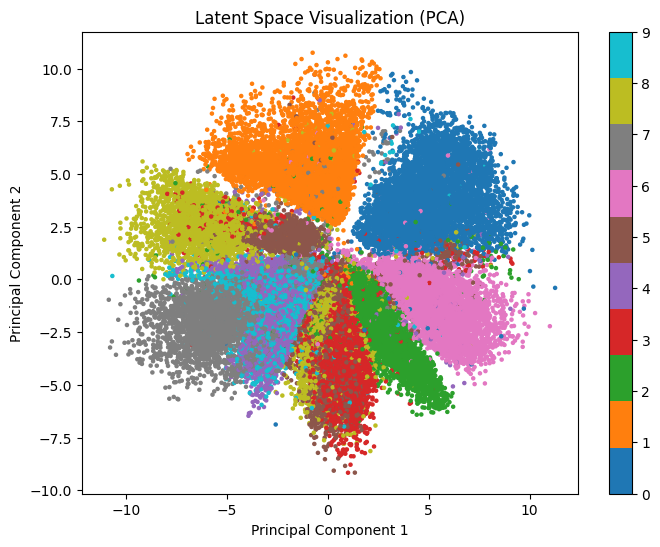

In [8]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

# Load your trained model
latent_dim = 2  # Adjust this according to your model

model = VAE(latent_dim, img_size).to(device)
model.load_state_dict(torch.load('vae.pth'))
model.eval()

# Define a function to encode the dataset into the latent space
def encode_dataset(model, dataloader):
    encoded_data = []
    labels = []
    with torch.no_grad():
        for x, label in dataloader:
            x = x.to(device)
            label = label.to(device)
            _, mu, _ = model.forward(x)
            encoded_data.append(mu.cpu().numpy())
            labels.append(label.cpu().numpy())
    encoded_data = np.concatenate(encoded_data)
    labels = np.concatenate(labels)
    return encoded_data, labels

# Encode the dataset into the latent space
encoded_data, labels = encode_dataset(model, train_loader)

n_components = 2
pca = PCA(n_components=n_components)
reduced_data = pca.fit_transform(encoded_data)

# Plot the reduced latent space
plt.figure(figsize=(8, 6))
plt.scatter(reduced_data[:, 0], reduced_data[:, 1], c=labels, cmap='tab10', s=5)
plt.colorbar()
plt.title('Latent Space Visualization (PCA)')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.show()


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

# Load your trained model
latent_dim = 2  # Adjust this according to your model

vae_model = VAE(latent_dim, img_size).to(device)
vae_model.load_state_dict(torch.load('vae.pth'))
vae_model.eval()

# Define a function to encode the dataset into the latent space
encoded_data = []
labels = []
with torch.no_grad():
  for x, label in train_loader:
    x = x.to(device)
    label = label.to(device)
    _, mu, _ = vae_model.forward(x)
    encoded_data.append(mu.cpu().numpy())
    labels.append(label.cpu().numpy())
encoded_data = np.concatenate(encoded_data)
labels = np.concatenate(labels)

# Plot the reduced latent space
plt.figure(figsize=(8, 6))
plt.scatter(encoded_data[:, 0], encoded_data[:, 1], c=labels, cmap='tab10', s=5)
plt.colorbar()
plt.title('Latent Space Visualization (PCA)')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.show()


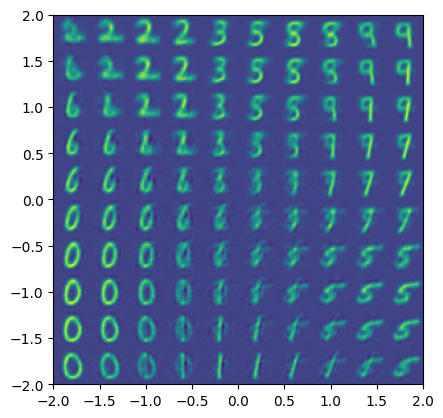

In [14]:
import seaborn as sns
from matplotlib import pyplot as plt

%matplotlib inline

def plot_reconstructed(model, ranges=((-2,2),(-2,2)), n_sample_points=10, image_dim=28):

    img = np.zeros((n_sample_points*image_dim, n_sample_points*image_dim))

    for i, y in enumerate(np.linspace(*ranges[0], n_sample_points)):
        for j, x in enumerate(np.linspace(*ranges[1], n_sample_points)):
            z = torch.Tensor([[x, y]])
            z = z.to(device)

            x_hat = model.decode(z)
            x_hat = x_hat.cpu().detach().numpy()
            img[
                (n_sample_points-1-i)*image_dim:(n_sample_points-1-i+1)*image_dim,
                j*image_dim:(j+1)*image_dim] = x_hat

    plt.imshow(img, extent=[*ranges[0], *ranges[1]])


vae_model = VAE(latent_dim, img_size).to(device)
vae_model.load_state_dict(torch.load('vae.pth'))
vae_model.eval()

plot_reconstructed(vae_model)

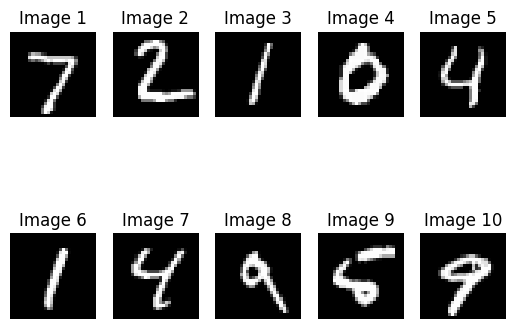

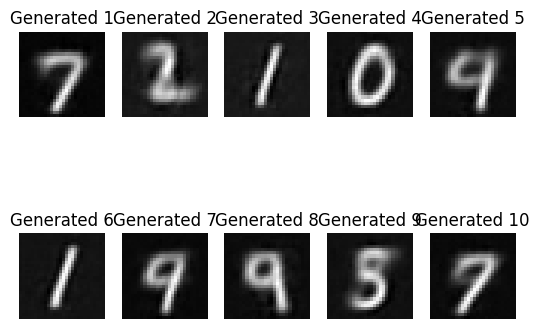

In [15]:
import torch
import matplotlib.pyplot as plt



batch = next(iter(test_loader))
images, labels = batch
# Assuming img_tensor is your torch tensor with size [10, 1, 28, 28]
img_tensor = torch.randn(10, 1, 28, 28)

# Loop through the batch and plot each image
for i in range(10):
    # Convert the tensor to numpy array
    img_array = images[i].squeeze().detach().numpy()

    # Plot the image
    plt.subplot(2, 5, i+1)  # Assuming a 2x5 grid for the subplots
    plt.imshow(img_array, cmap='gray')
    plt.axis('off')  # Turn off axis labels
    plt.title(f'Image {i+1}')

plt.show()

epoch = 9
vae_model = VAE(latent_dim, img_size).to(device)
vae_model.load_state_dict(torch.load('vae.pth'))

vae_model.eval()

images = images.to(device)
labels = labels.to(device)

x_reconstructed, mu, logvar = vae_model.forward(images)

# Loop through the batch and plot each image
for i in range(10):
    # Convert the tensor to numpy array
    img_array = x_reconstructed[i].squeeze().cpu().detach().numpy()
    #img_array = np.clip(img_array/255.,0,1)
    # Plot the image
    plt.subplot(2, 5, i+1)  # Assuming a 2x5 grid for the subplots
    plt.imshow(img_array, cmap='gray')
    plt.axis('off')  # Turn off axis labels
    plt.title(f'Generated {i+1}')

plt.show()